# Predicting the Stock Market Prices

### **Data Description:** 

In this mission, we'll be working with a csv file containing index prices. Each row in the file contains a **daily record of the price of the S&P500 Index from 1950 to 2015**. The dataset is stored in sphist.csv.

The columns of the dataset are:

    Date -- The date of the record.
    Open -- The opening price of the day (when trading starts).
    High -- The highest trade price during the day.
    Low -- The lowest trade price during the day.
    Close -- The closing price for the day (when trading is finished).
    Volume -- The number of shares traded.
    Adj Close -- The daily closing price, adjusted for corporate actions.

**We'll be using this dataset to develop a predictive model. We'll train the model with data from 1950-2012, and try to make predictions from 2013-2015.**

In [50]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Importing the statistics module
from statistics import mean
from statistics import median

def linearReg(x_train, y_train, x_test, y_test):
    
    lm = LinearRegression()
    lm.fit(x_train, y_train)

    y_pred = lm.predict(x_test)

    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Prices: $Y_i$")
    plt.ylabel("Predicted Prices: $\hat{Y}_i$")
    plt.title("Actual Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
    plt.show()

    # Calculating the error
    delta_y = y_test - y_pred;
    print("Mean Absolute Error (MAE) = " + str(mean(abs(delta_y))))

    # Calculating the percentage error
    delta_y_percentage = (y_test - y_pred)/ y_test;

    print(bold + "Median Absolute Percentage Error (MAPE) = " + 
              str(round(median(abs(delta_y_percentage)), 2)*100) + "%" + end)

In [54]:
from sklearn.preprocessing import StandardScaler

def trainTestSplit(sp_augmented, predictWeek = False):
    
    # Train dataset would contain rows with a date less than 2013-01-01
    train = sp_augmented[sp_augmented["Date"] < datetime(year=2013, month=1, day=1)]
    test = sp_augmented[sp_augmented["Date"] >= datetime(year=2013, month=1, day=1)]

    
    # Separate Train dataset & remove unusable columns for prediction
    # if % change in a week is to be predicted, then response variable 
    # should be set to percentage change in closing price over a week.
    if predictWeek:
        y_train = train['closePerChange']
        x_train = train.drop(
            ['closePerChange', 'Close', 'High', 'Low', 
             'Open', 'Volume', 'Adj Close', 'Date'], axis=1)
    else:
        y_train = train['Close']
        x_train = train.drop(
            ['Close', 'High', 'Low', 'Open', 
             'Volume', 'Adj Close', 'Date'], axis=1)

    # Separate Test dataset & remove unusable columns for prediction
    if predictWeek:
        y_test = test['closePerChange']
        x_test = test.drop(
            ['closePerChange', 'Close', 'High', 'Low', 
             'Open', 'Volume', 'Adj Close', 'Date'], axis=1)
    else:
        y_test = test['Close']
        x_test = test.drop(
            ['Close', 'High', 'Low', 'Open', 
             'Volume', 'Adj Close', 'Date'], axis=1)

#     # Standardisation.
#     scaler = StandardScaler(copy=False).fit(x_train)
#     x_train = scaler.transform(x_train)
    
#     scaler = StandardScaler(copy=False)
#     y_train = np.squeeze(scaler.fit_transform(y_train.reshape(-1, 1)))

#     scaler = StandardScaler(copy=False).fit(x_test)
#     x_test = scaler.transform(x_test)
    
#     scaler = StandardScaler(copy=False)
#     y_test = np.squeeze(scaler.fit_transform(y_test.reshape(-1, 1)))

    print("\n\n*** Train Dataset Outcome Variables ***")
    print(y_train.head(5))
    print("\n\n*** Train Dataset Input Variables ***")
    print(x_train.head(5))
    print("\n\n*** Test Dataset Outcome Variables ***")
    print(y_test.head(5))
    print("\n\n*** Test Dataset Input Variables ***")
    print(x_test.head(5))
    
    return x_train, y_train, x_test, y_test


# Prediction of Stock Prices: Week Ahead

To predict % change in stock price after a week, we can use features averaging previous 'n' days coupled with % change in stock price after a week, as the response variable, y as training data. In test data also, a 7-day forward shift in the closing price is introduced to compare the % change against prediction.



*** Dataset After Augmented Values ***
            Date       Open       High        Low      Close     Volume  \
16194 1951-08-01  22.510000  22.510000  22.510000  22.510000  1680000.0   
16193 1951-08-02  22.820000  22.820000  22.820000  22.820000  2130000.0   
16192 1951-08-03  22.850000  22.850000  22.850000  22.850000  1570000.0   
16191 1951-08-06  23.010000  23.010000  23.010000  23.010000  1600000.0   
16190 1951-08-07  23.030001  23.030001  23.030001  23.030001  1810000.0   
16189 1951-08-08  22.930000  22.930000  22.930000  22.930000  1410000.0   
16188 1951-08-09  22.840000  22.840000  22.840000  22.840000  1500000.0   
16187 1951-08-10  22.790001  22.790001  22.790001  22.790001  1260000.0   
16186 1951-08-13  22.799999  22.799999  22.799999  22.799999  1320000.0   
16185 1951-08-14  22.700001  22.700001  22.700001  22.700001  1180000.0   

       Adj Close  closePerChange  mean_7by30  std_7by30  mean_7by14  std_7by14  
16194  22.510000        1.243896    1.028349   0.378

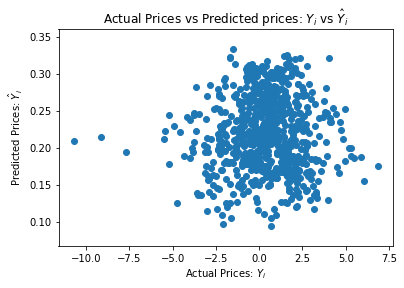

Mean Absolute Error (MAE) = 1.4682141984586512
Median Absolute Percentage Error (MAPE) = 93.0%


In [56]:

# print(sp_augmented.head(5))
# drop the added features for daily prediction
sp_augmented = sp_augmented.drop(['mean_365', 'std_365', 'mean_5by365'], axis=1)

# closePrices.shift(-7) would give the closing price after a week.
closePrices = pd.DataFrame(sp_augmented.Close)
shiftedByWeek = closePrices.shift(-7)

# to find the % change in closing price after a week
closePriceChange = 100 * (shiftedByWeek - closePrices)/closePrices 
sp_augmented['closePerChange'] = closePriceChange

# The average price for the past 7 days.
# The standard deviation of the price over the past 7 days
shifted = closePrices.shift(1)
window = shifted.rolling(window=7)
means_7 = window.mean()
std_7 = window.std()
# sp_augmented['mean_7'] = means_7
# sp_augmented['std_7'] = std_7

window = shifted.rolling(window=30)
means_30 = window.mean()
std_30 = window.std()
sp_augmented['mean_7by30'] = means_7/ means_30
sp_augmented['std_7by30'] = std_7/ std_30

# The ratio between the average price 
# for the past 7 days, and the average 
# price for the past 14 days.
window = shifted.rolling(window=14)
means_14 = window.mean()
std_14 = window.std()
sp_augmented['mean_7by14'] = means_7/ means_14
sp_augmented['std_7by14'] = std_7/ std_14


# Use the dropna method to remove any rows with NaN values. 
# Pass in the axis=0 argument to drop rows.
sp_augmented = sp_augmented.dropna(axis = 0)

print("\n\n*** Dataset After Augmented Values ***")
print(sp_augmented.head(10))

# To split into train and test data to do linear regression
x_train, y_train, x_test, y_test = trainTestSplit(sp_augmented, predictWeek = True)
linearReg(x_train, y_train, x_test, y_test)

# MAE vs MAPE Error Metric

MAE error metric is not interpretable, since the value of MAE can range from 0 to infinity. We can't understand how good the model performed. Hence it would be better to compute Percentage error and even better would be to compute median (instead of mean) so that the perturbation caused by outliers could be eliminated.

Median Absolute Percentage Error (MAPE) would be a far more intrepretable metric, resilient to outliers.

# Prediction of Stock Prices: Day Ahead

Percentage error for weekly prediction is unacceptably high. This was expected as stock prediction is an extremely hard problem, to get even a better than random model. 

Lets try to predict % change in stock price prior to a day. We can use features, mean and standard deviation of previous 365 days & The ratio between the average price for the past 5 days, and the average price for the past 365 days. The response variable, y, would be the closing price. A 1-day forward shift in the closing price, so that the closing price of the present day (future data) shouldn't be included in prediction.



*** Dataset After Augmented Values ***
            Date       Open       High        Low      Close     Volume  \
16224 1951-06-19  22.020000  22.020000  22.020000  22.020000  1100000.0   
16223 1951-06-20  21.910000  21.910000  21.910000  21.910000  1120000.0   
16222 1951-06-21  21.780001  21.780001  21.780001  21.780001  1100000.0   
16221 1951-06-22  21.549999  21.549999  21.549999  21.549999  1340000.0   
16220 1951-06-25  21.290001  21.290001  21.290001  21.290001  2440000.0   

       Adj Close   mean_365   std_365  mean_5by365  
16224  22.020000  19.447726  1.790253     1.120954  
16223  21.910000  19.462411  1.789307     1.125246  
16222  21.780001  19.476274  1.788613     1.128142  
16221  21.549999  19.489562  1.787659     1.126757  
16220  21.290001  19.502082  1.786038     1.121008  


*** Train Dataset Outcome Variables ***
16224    22.020000
16223    21.910000
16222    21.780001
16221    21.549999
16220    21.290001
Name: Close, dtype: float64


*** Train Dataset Input

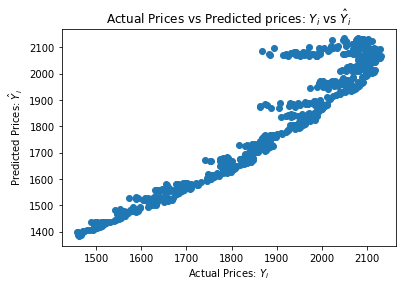

Mean Absolute Error (MAE) = 98.94921147104225
Median Absolute Percentage Error (MAPE) = 6.0%


In [55]:
import pandas as pd
import numpy as np
from datetime import datetime

# used to format headings 
bold = '\033[1m'
end = '\033[0m'

# Read the s&p 500 input data set and sorting based on date.
sp500 = pd.read_csv("sphist.csv", index_col=False)
sp500["Date"] = pd.to_datetime(sp500["Date"])
sp_sorted = sp500.sort_values("Date")

# To do feature engineering - take mean of previous rows
closePrices = pd.DataFrame(sp_sorted.Close)

# Need to shift by 1 coz otherwise it will add up present value also
# Adding present value to the mean is same as giving the 
# predicted value (outcome)along with the training data.
# This will hurt prediction model
shifted = closePrices.shift(1)

# The average price for the past 365 days.
# The standard deviation of the price over the past 365 days
window = shifted.rolling(window=365)
means_365 = window.mean()
std_365 = window.std()
sp_sorted['mean_365'] = means_365
sp_sorted['std_365'] = std_365

# The ratio between the average price 
# for the past 5 days, and the average 
# price for the past 365 days.
window = shifted.rolling(window=5)
means_5 = window.mean()
sp_sorted['mean_5by365'] = means_5/ means_365

# Some of the indicators use 365 days of historical data, and the dataset starts 
# on 1950-01-03. Thus, any rows that fall before 1951-01-03 don't have enough 
# historical data to compute all the indicators. 
sp_augmented = sp_sorted[sp_sorted["Date"] > datetime(year=1951, month=1, day=2)]

# Use the dropna method to remove any rows with NaN values. 
# Pass in the axis=0 argument to drop rows.
sp_augmented = sp_augmented.dropna(axis = 0)

print("\n\n*** Dataset After Augmented Values ***")
print(sp_augmented.head(5))

# To split into train and test data to do linear regression
x_train, y_train, x_test, y_test = trainTestSplit(sp_augmented, predictWeek = False)
linearReg(x_train, y_train, x_test, y_test)

MAPE of 6.0% is a much better prediction result than the previous weekly prediction attempt.

# Conclusion

1) **In daily forecast, Actual and Predicted prices are almost linear. Hence the daily prediction model is working fine**, though the error can be further reduced with a better model such as randomforest or using feature engineering techniques such as previous volume, highest/ lowest price in the past year etc.

2) For a financial company, another way to reframe this problem would be **to perceive the problem as a classification problem, instead of regression problem.** If we can predict, whether the price of a particular stock would go up or down, on next day or a period of time then such a system is very useful.

3) There was a Kaggle competition on similar lines and all of the good solutions just predicted 0% change in price most of the times.

# Potential Improvements

a) Learn the domain more and engineer very domain specific features. 

b) Implement this paper for a Deep Learning  based momentum trading strategy: Applying Deep Learning To Enhance Momentum Trading Strategies In Stocks by Lawrence Takeuchi & Yu-Ying (Albert) Lee (publicly available at http://cs229.stanford.edu